Let's discover relations between natures and each agency.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# Load data

In [2]:
calls = pd.read_csv('../data/callsforservicefiltered.csv')
ems_calls = pd.DataFrame()
gcf_calls = pd.DataFrame()
gcsd_calls = pd.DataFrame()
aco_calls = pd.DataFrame()

/home/oana/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's clean it up.

In [3]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
calls = calls[calls.nature != 'TRANSPORT TO ANIMAL SHELTER']
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
calls = calls.drop(columns = ['statbeat','ra'])
calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature']!=x['nature2']
                        else x['nature'] for i,x in calls.iterrows()]
calls = calls.drop(columns = ['nature','nature2'])
calls = calls.rename(columns={'actualnature' : 'nature'})

Let's split the data into 4 data sets based on the 4 agencies.

In [4]:
ems_calls = calls[calls.agency == 'EMS']
aco_calls = calls[calls.agency == 'ACO']
gcsd_calls = calls[calls.agency == 'GCSD']
gcf_calls = calls[calls.agency == 'GCF']

## 1. First 5 leading natures for calls per agency
Let's see what are the top reasons per agency most people call about.

Let's group all tuples into groups based on the same call nature

In [5]:
# warning: inPlace parameter has a bug! Do not use it in sort_values(), as the object returned is Null
aco_groupby_nature = aco_calls.groupby(['nature']).size().reset_index(name='count')
aco_groupby_nature = aco_groupby_nature.sort_values(by='count', ascending=False)
ems_groupby_nature = ems_calls.groupby(['nature']).size().reset_index(name='count')
ems_groupby_nature = ems_groupby_nature.sort_values(by='count', ascending=False)
gcf_groupby_nature = gcf_calls.groupby(['nature']).size().reset_index(name='count')
gcf_groupby_nature = gcf_groupby_nature.sort_values(by='count', ascending=False)
gcsd_groupby_nature = gcsd_calls.groupby(['nature']).size().reset_index(name='count')
gcsd_groupby_nature = gcsd_groupby_nature.sort_values(by='count', ascending=False)

Print the top 5 calls' nature in each call category and see which is the biggest.

In [6]:
def create_plot(ylabel, title, xlabels, xsizes):
    
    y_pos = np.arange(len(xlabels))    
    plt.bar(y_pos, xsizes, align='center', alpha=1)
    plt.xticks(y_pos, xlabels, rotation='vertical')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

ACO top 5 reasons for calls
                      nature  count
34         ZRUNNING AT LARGE  13003
6   ZALLOWED TO RUN AT LARGE   8160
15                 ZCONFINED   7654
14            ZCHECK WELFARE   6595
22                ZFOLLOW UP   5020


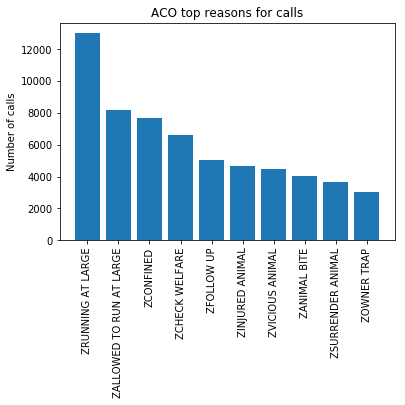


EMS top 5 reasons for calls
                            nature  count
76                     SICK PERSON  63192
53  FALLS-BACK INJURIES(TRAUMATIC)  54033
26              BREATHING PROBLEMS  39463
35          CONVALESCENT TRANSPORT  31320
31                      CHEST PAIN  30551


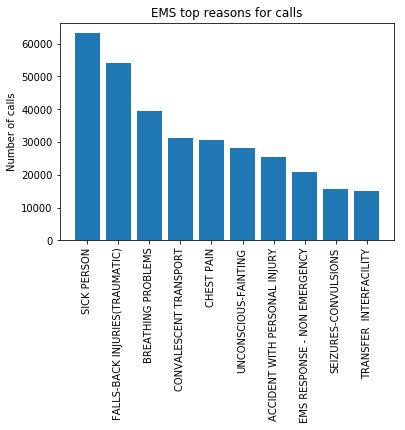


GCF top 5 reasons for calls
                            nature  count
6    ACCIDENT WITH PERSONAL INJURY   6569
44  FALLS-BACK INJURIES(TRAUMATIC)   6565
22              BREATHING PROBLEMS   6419
15                          ALARMS   6008
30   CITIZEN ASSIST / SERVICE CALL   5680


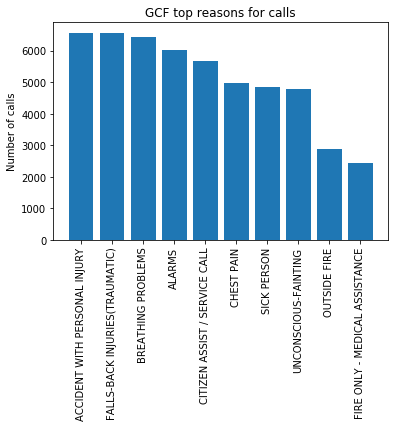


GCSD top 5 reasons for calls
                      nature   count
139             TRAFFIC STOP  112814
29             BURGLAR ALARM   32867
97   LEGAL PAPER / COMPLAINT   18064
47     C22-WARRANT-GCSD ONLY   17215
129      SUSPICIOUS ACTIVITY   17186


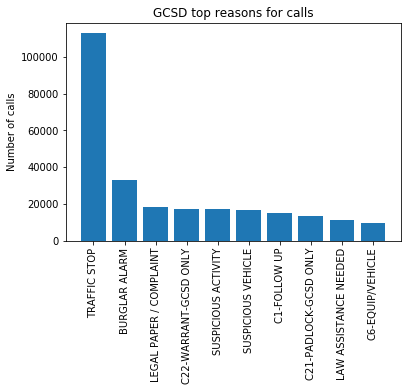

In [7]:
font = {'family':'normal',
#         'weight':'bold',
       'size':5}
# matplotlib.rc('font', **font)
print('ACO top 5 reasons for calls')
print(aco_groupby_nature.head())
aco_top_natures = aco_groupby_nature.head(10)['nature']
no_calls_aco = aco_groupby_nature.head(10)['count']
create_plot('Number of calls', 'ACO top reasons for calls', 
            aco_top_natures, no_calls_aco)

print('\nEMS top 5 reasons for calls')
print(ems_groupby_nature.head())
ems_top_natures = ems_groupby_nature.head(10)['nature']
no_calls_ems = ems_groupby_nature.head(10)['count']
create_plot('Number of calls', 'EMS top reasons for calls', 
            ems_top_natures, no_calls_ems)

print('\nGCF top 5 reasons for calls')
print(gcf_groupby_nature.head())
gcf_top_natures = gcf_groupby_nature.head(10)['nature']
no_calls_gcf = gcf_groupby_nature.head(10)['count']
create_plot('Number of calls', 'GCF top reasons for calls', 
            gcf_top_natures, no_calls_gcf)

print('\nGCSD top 5 reasons for calls')
print(gcsd_groupby_nature.head())
gcsd_top_natures = gcsd_groupby_nature.head(10)['nature']
no_calls_gcsd = gcsd_groupby_nature.head(10)['count']
create_plot('Number of calls', 'GCSD top reasons for calls', 
            gcsd_top_natures, no_calls_gcsd)

## 2. Natures with the biggest variance in calls
Let's see which natures have the biggest variance in calls - aka which one are trending.
We will do the computation if the nature is present for at least 3 years, to avoid biased results.
Also we will remove calls that were made in 2018 or 2012, as the data for those years is incomplete and we will obtain biased results.

In [8]:
def find_call_variance(data):

    agency = data['agency'][0] 
    data_filtered = data[data.year != 2018]
    data_filtered = data_filtered[data_filtered.year != 2012]    
    data_calls_variance = pd.DataFrame(columns=['agency', 'nature', 'variance'])          
    data_with_counts = data_filtered.groupby(['nature', 'year']).size().reset_index(name='count')
    data_with_counts = data_with_counts.sort_values(by='year', ascending=True)
    grouped_data = data_with_counts.groupby(['nature'])
    natures = []
    variance_calls = []    
    for group in grouped_data: 
        calls_group = group[1]
        mean = calls_group['count'].mean()         
        if (mean>50) and (calls_group.tail(1).year == 2017).bool() and calls_group.shape[0] > 2:                        
            calls_2017 = calls_group['count'].tail(1)
            variance_call = (int)(calls_2017-mean)/mean
            natures.append(group[0])
            variance_calls.append(variance_call)        
            
    data_calls_variance['nature'] = natures
    data_calls_variance['variance'] = variance_calls
    return data_calls_variance

First group the data by nature and year and obtain the no of calls for each group.
Then, for each call nature, see how the last year's calls varies according to the mean of all the calls from all the years for that nature.
Then sort the data and print the first 3 biggest differences.
Notes:
3. Compute values for natures with at least x calls

ACO variance
   agency                    nature  variance
26    ACO  ZWELFARE CHECK FOLLOW UP  1.134396
17    ACO          ZPUBLIC NUISANCE  0.906652
5     ACO                   ZASSIST  0.799201


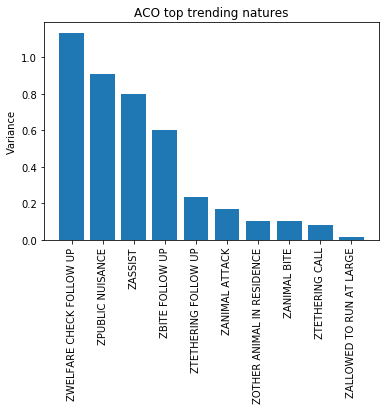

EMS variance
   agency                         nature  variance
15    EMS  DEAD BODY TRANSPORT-PTAR ONLY  0.421053
28    EMS   OVERDOSE-INGESTION-POISONING  0.348837
33    EMS           STAB / GUNSHOT WOUND  0.219665


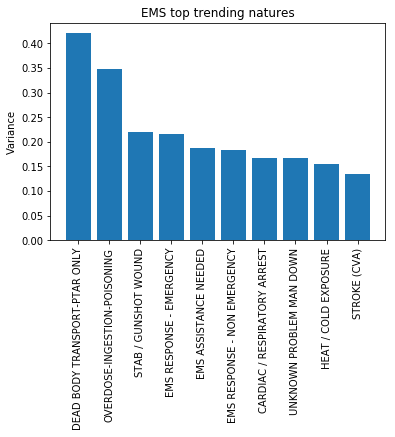

GCSD variance
   agency                   nature  variance
28   GCSD        C7-PREMISES CHECK  0.939902
54   GCSD      NARCOTICS VIOLATION  0.918239
34   GCSD  DEAD BODY INVESTIGATION  0.683453


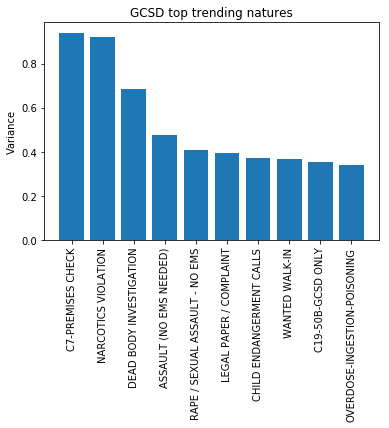

GCF variance
   agency                          nature  variance
12    GCF  FALLS-BACK INJURIES(TRAUMATIC)  0.351078
20    GCF    OVERDOSE-INGESTION-POISONING  0.326425
18    GCF                      MUTUAL AID  0.269570


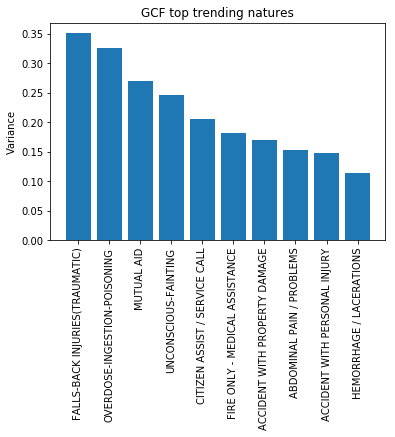

In [9]:
aco_calls.reset_index(drop=True, inplace=True)
aco_variance = find_call_variance(aco_calls)
aco_variance.sort_values(by='variance', ascending=False, inplace=True)
aco_variance['agency'] = 'ACO'
print('ACO variance')
print(aco_variance.head(3))
aco_trending_natures = aco_variance.head(10)['nature']
aco_variance = aco_variance.head(10)['variance']
create_plot('Variance', 'ACO top trending natures', 
            aco_trending_natures, aco_variance)

ems_calls.reset_index(drop=True, inplace=True)
ems_variance = find_call_variance(ems_calls)
ems_variance.sort_values(by='variance', ascending=False, inplace=True)
ems_variance['agency'] = 'EMS'
print('EMS variance')
print(ems_variance.head(3))
ems_trending_natures = ems_variance.head(10)['nature']
ems_variance = ems_variance.head(10)['variance']
create_plot('Variance', 'EMS top trending natures', 
            ems_trending_natures, ems_variance)

gcsd_calls.reset_index(drop=True, inplace=True)
gcsd_variance = find_call_variance(gcsd_calls)
gcsd_variance.sort_values(by='variance', ascending=False, inplace=True)
gcsd_variance['agency'] = 'GCSD'
print('GCSD variance')
print(gcsd_variance.head(3))
gcsd_trending_natures = gcsd_variance.head(10)['nature']
gcsd_variance = gcsd_variance.head(10)['variance']
create_plot('Variance', 'GCSD top trending natures', 
            gcsd_trending_natures, gcsd_variance)

gcf_calls.reset_index(drop=True, inplace=True)
gcf_variance = find_call_variance(gcf_calls)
gcf_variance.sort_values(by='variance', ascending=False, inplace=True)
gcf_variance['agency'] = 'GCF'
print('GCF variance')
print(gcf_variance.head(3))
gcf_trending_natures = gcf_variance.head(10)['nature']
gcf_variance = gcf_variance.head(10)['variance']
create_plot('Variance', 'GCF top trending natures', 
            gcf_trending_natures, gcf_variance)
#if you want to keep hierarchical indexing, to retrieve data by chunks:
#result = pd.concat(frames, keys=['x', 'y', 'z'])

## 3. Natures with highest priority per agency
Let's see which are the natures with the highest priority per agency. This info will lead to better allocation of the resources.
Also, among the natures with highest priority, see which months have the highest amount of calls; see how the no of phone calls for those natures are spread throughout the year.

In [10]:
def find_highest_p_natures(data):
    
#     filtering the data to have only natures with highest priority 
    data_highestP_calls = data[data.priority == 'P']
    groupBy_nature = data_highestP_calls.groupby(['nature']).size().reset_index(name='count')
    highest_p_natures = groupBy_nature.sort_values(by='count', ascending=False)
    return highest_p_natures

ACO
ZINJURED ANIMAL 4628


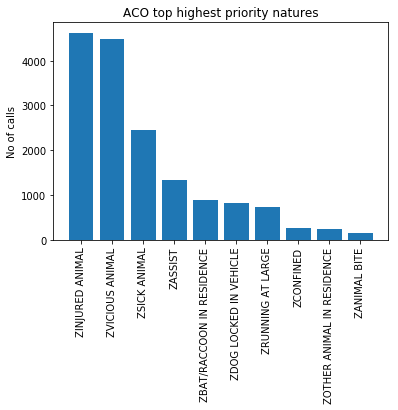

EMS
CARDIAC / RESPIRATORY ARREST 3542


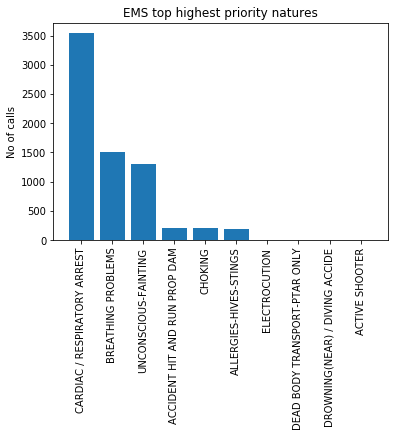

GCSD
OVERDOSE-INGESTION-POISONING 902


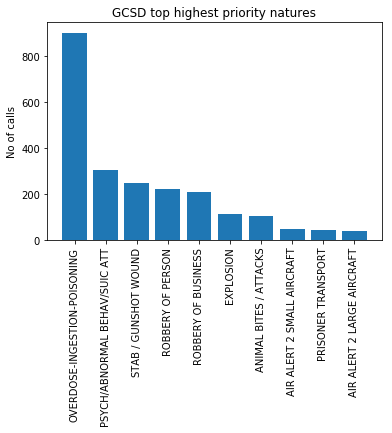

GCF
ACCIDENT WITH PERSONAL INJURY 6177


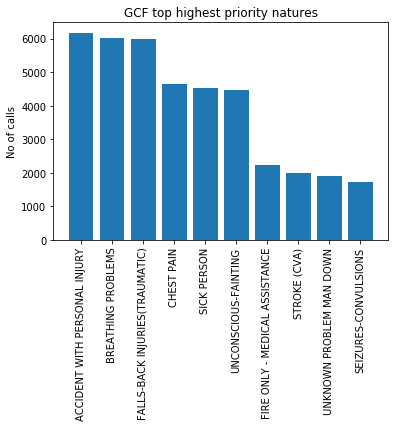

In [11]:
aco_highestP_natures = find_highest_p_natures(aco_calls)
aco_highestP_nature = aco_highestP_natures.head(1).iloc[0]['nature']
aco_count = aco_highestP_natures.head(1).iloc[0]['count']
print('ACO')
print(aco_highestP_nature, aco_count)
aco_highest_natures = aco_highestP_natures.head(10)['nature']
aco_highest_counts = aco_highestP_natures.head(10)['count']
create_plot('No of calls', 'ACO top highest priority natures', 
            aco_highest_natures, aco_highest_counts)

ems_highestP_natures = find_highest_p_natures(ems_calls)
ems_highestP_nature = ems_highestP_natures.head(1).iloc[0]['nature']
ems_count = ems_highestP_natures.head(1).iloc[0]['count']
print('EMS')
print(ems_highestP_nature, ems_count)
ems_highest_natures = ems_highestP_natures.head(10)['nature']
ems_highest_counts = ems_highestP_natures.head(10)['count']
create_plot('No of calls', 'EMS top highest priority natures', 
            ems_highest_natures, ems_highest_counts)

gcsd_highestP_natures = find_highest_p_natures(gcsd_calls)
gcsd_highestP_nature = gcsd_highestP_natures.head(1).iloc[0]['nature']
gcsd_count = gcsd_highestP_natures.head(1).iloc[0]['count']
print('GCSD')
print(gcsd_highestP_nature, gcsd_count)
gcsd_highest_natures = gcsd_highestP_natures.head(10)['nature']
gcsd_highest_counts = gcsd_highestP_natures.head(10)['count']
create_plot('No of calls', 'GCSD top highest priority natures', 
            gcsd_highest_natures, gcsd_highest_counts)

gcf_highestP_natures = find_highest_p_natures(gcf_calls)
gcf_highestP_nature = gcf_highestP_natures.head(1).iloc[0]['nature']
gcf_count = gcf_highestP_natures.head(1).iloc[0]['count']
print('GCF')
print(gcf_highestP_nature, gcf_count)
gcf_highest_natures = gcf_highestP_natures.head(10)['nature']
gcf_highest_counts = gcf_highestP_natures.head(10)['count']
create_plot('No of calls', 'GCF top highest priority natures', 
            gcf_highest_natures, gcf_highest_counts)

Let's see the distribution of the calls for each month for each highest nature of each agency.

In [12]:
def get_nature_month_distribution(data, nature):
    
    data = data[data.nature == nature] 
    data_filtered = data[data.year != 2018]
    data_filtered = data_filtered[data_filtered.year != 2012]    
    groupBy_month = data_filtered.groupby(['month']).size().reset_index(name='count')
    call_distribution = groupBy_month.sort_values(by='month', ascending=True)    
    call_distribution['count'] = call_distribution['count']/12
    return call_distribution

    month      count
0       1  18.166667
1       2  17.750000
2       3  18.916667
3       4  27.583333
4       5  37.166667
5       6  40.083333
6       7  33.500000
7       8  29.583333
8       9  26.333333
9      10  25.833333
10     11  19.833333
11     12  20.416667


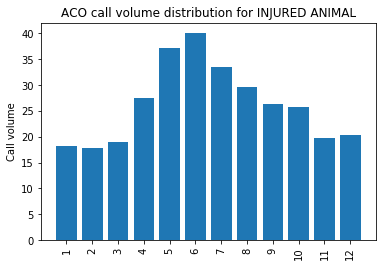

    month      count
0       1  32.000000
1       2  26.833333
2       3  29.333333
3       4  29.166667
4       5  33.083333
5       6  28.166667
6       7  24.916667
7       8  28.666667
8       9  30.083333
9      10  31.416667
10     11  31.666667
11     12  29.333333


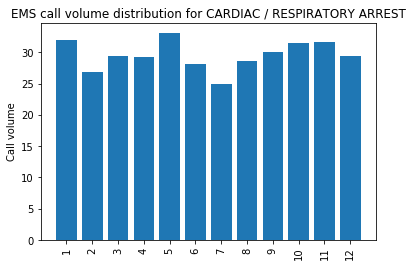

    month     count
0       1  4.666667
1       2  4.250000
2       3  4.416667
3       4  4.333333
4       5  6.166667
5       6  4.833333
6       7  5.500000
7       8  4.666667
8       9  6.416667
9      10  5.000000
10     11  5.666667
11     12  4.083333


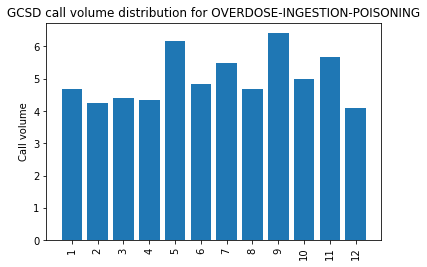

    month      count
0       1  40.583333
1       2  33.250000
2       3  37.166667
3       4  35.916667
4       5  37.666667
5       6  36.500000
6       7  32.916667
7       8  37.916667
8       9  34.916667
9      10  42.500000
10     11  37.250000
11     12  44.750000


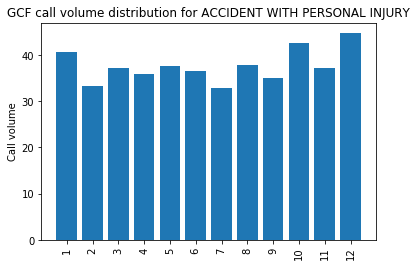

In [14]:
aco_call_distrub = get_nature_month_distribution(aco_calls, aco_highestP_nature)
print(aco_call_distrub)
months = aco_call_distrub['month']
aco_variance = aco_call_distrub['count']
create_plot('Call volume', 'ACO call volume distribution for INJURED ANIMAL', 
            months, aco_variance)

ems_call_distrub = get_nature_month_distribution(ems_calls, ems_highestP_nature)
print(ems_call_distrub)
ems_variance = ems_call_distrub['count']
create_plot('Call volume', 'EMS call volume distribution for CARDIAC / RESPIRATORY ARREST', 
            months, ems_variance)

gcsd_call_distrub = get_nature_month_distribution(gcsd_calls, gcsd_highestP_nature)
print(gcsd_call_distrub)
gcsd_variance = gcsd_call_distrub['count']
create_plot('Call volume', 'GCSD call volume distribution for OVERDOSE-INGESTION-POISONING', 
            months, gcsd_variance)

gcf_call_distrub = get_nature_month_distribution(gcf_calls, gcf_highestP_nature)
print(gcf_call_distrub)
gcf_variance = gcf_call_distrub['count']
create_plot('Call volume', 'GCF call volume distribution for ACCIDENT WITH PERSONAL INJURY', 
            months, gcf_variance)